In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NULL_SUBCARRIERS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 64, 65, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]

In [50]:
filename = "2024-04-11-14-37-23.csv"

In [3]:
data = pd.read_csv("../testing-data/2024-04-11-14-37-23.csv")

In [4]:
data

timestamp  rssi                                                csi  \
0             0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 15,...   
1             0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -...   
2             0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, -16...   
3             0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, -19...   
4             0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, -14...   
...         ...   ...                                                ...   
1149          0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 7, ...   
1150          0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, -5...   
1151          0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, -3, -1...   
1152          0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -12...   
1153          0    11  [84, -64, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 1,...   

      voxel_no  inter_voxel_no activity  
0            1               5  Walking  
1            1               5  Walking  
2            1               5  Walking  
3            1               5  Walking  
4            1               5  Walking  
...        ...             ...      ...  
1149         6               5  Walking  
1150         6               5  Walking  
1151         6               5  Walking  
1152         6               5  Walking  
1153         6               5  Walking  

[1154 rows x 6 columns]

In [5]:
data_rows = data.iloc[:5]

In [6]:
# Define a function to remove null subcarriers
def remove_null_subcarriers(csi_list):
    return [value for index, value in enumerate(csi_list) if index not in NULL_SUBCARRIERS]

In [7]:
data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
data_rows

/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_22624/1020922514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)


timestamp  rssi                                                csi  \
0          0    11  [1, 15, 1, 15, 1, 16, -1, 17, -1, 17, -1, 16, ...   
1          0    11  [-10, -13, -10, -14, -10, -15, -10, -15, -9, -...   
2          0    11  [5, -16, 6, -17, 6, -17, 7, -18, 8, -17, 8, -1...   
3          0    11  [5, -19, 5, -18, 6, -19, 8, -18, 9, -18, 8, -1...   
4          0    11  [9, -14, 9, -14, 10, -14, 12, -15, 12, -14, 11...   

   voxel_no  inter_voxel_no activity  
0         1               5  Walking  
1         1               5  Walking  
2         1               5  Walking  
3         1               5  Walking  
4         1               5  Walking

In [8]:
# Calculate amplitude and phase using vectorized operations
csi_array = np.array(data_rows['csi'].tolist())
amplitudes = np.sqrt(csi_array[:, ::2]**2 + csi_array[:, 1::2]**2)
phases = np.arctan2(csi_array[:, ::2], csi_array[:, 1::2])

In [9]:
vectors = pd.DataFrame()
for subcarrier in range(1, amplitudes.shape[1] + 1):
    subcarrier_amplitudes = []
    subcarrier_phases = []
    for i in range(len(amplitudes)):
        subcarrier_amplitudes.append(amplitudes[i][subcarrier-1])
        subcarrier_phases.append(phases[i][subcarrier-1])
    row_to_append = pd.DataFrame([{'subcarrier': subcarrier, 'amplitude': subcarrier_amplitudes, 'phase': subcarrier_phases}])
    vectors = pd.concat([vectors, row_to_append])

In [10]:
connection = sqlite3.connect("../database/rti.db")

In [11]:
cursor = connection.cursor()

In [12]:
activities = ['Walking', 'Standing-Stationary', 'Standing-Movement', 'SittingDown-Stationary', 'SittingDown-Movement']

In [13]:
euclidean_distances = pd.DataFrame()
for _, row in vectors.iterrows(): #for each subcarrier
    #for each voxel get the vector for each specific subcarrier
    subcarrier = row['subcarrier']
    for voxel in range(1, 10):
        #generate heat map for each activity
        for i in range(len(activities)):
            res_cursor = cursor.execute("SELECT * FROM distance_vector WHERE subcarrier = ? AND voxel = ? AND activity = ?", [subcarrier, voxel, activities[i]])
            result = res_cursor.fetchone()
            amplitude_vector = np.array(eval(result[3]))
            phase_vector = np.array(eval(result[4]))
            # Calculate Euclidean distance
            amplitude_euclidean_distance = np.linalg.norm(row['amplitude'] - amplitude_vector)
            phase_euclidean_distance = np.linalg.norm(np.array(row['phase']) - phase_vector)
            row_to_append = pd.DataFrame([{'voxel': voxel, 'subcarrier': subcarrier, 'activity': activities[i], 'amplitude_diff': amplitude_euclidean_distance, 'phase_diff': phase_euclidean_distance}])
            euclidean_distances = pd.concat([euclidean_distances, row_to_append])

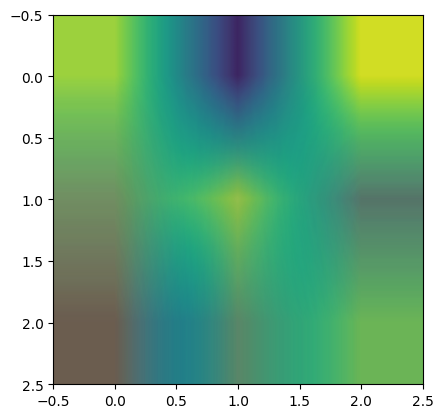

In [50]:
graph_data = []
for i in range(1, 53):
    subcarrier_graph_data = euclidean_distances.loc[(euclidean_distances['subcarrier'] == i) & (euclidean_distances['activity'] == 'Standing-Movement')]
    graph_data.append(np.array(subcarrier_graph_data['amplitude_diff']).reshape(3,3))

plt.imshow(graph_data[0], cmap=plt.cm.viridis_r, interpolation='nearest')
for i in range(1, len(graph_data)-1):
     alpha = 1.0 - (i / len(graph_data))
     plt.imshow(graph_data[i], cmap=plt.cm.viridis_r, alpha = alpha, interpolation='bilinear')
plt.show()

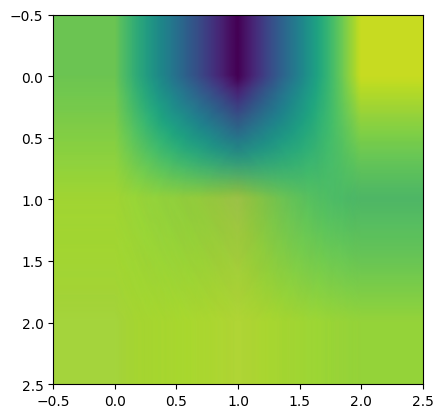

In [49]:
graph_data = []
for i in range(1, 53):
    subcarrier_graph_data = euclidean_distances.loc[(euclidean_distances['subcarrier'] == i) & (euclidean_distances['activity'] == 'Standing-Stationary')]
    graph_data.append(np.array(subcarrier_graph_data['amplitude_diff']).reshape(3,3))

plt.imshow(graph_data[0], cmap=plt.cm.viridis_r, interpolation='nearest')
for i in range(1, len(graph_data)-1):
    alpha = 1.0 - (i / len(graph_data))
    plt.imshow(graph_data[i], cmap=plt.cm.viridis_r, alpha = alpha, interpolation='bilinear')
plt.show()

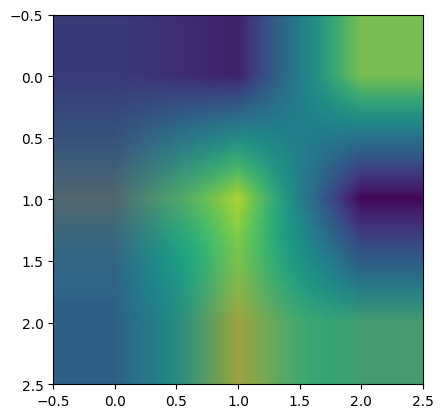

In [51]:
graph_data = []
for i in range(1, 53):
    subcarrier_graph_data = euclidean_distances.loc[(euclidean_distances['subcarrier'] == i) & (euclidean_distances['activity'] == 'Walking')]
    graph_data.append(np.array(subcarrier_graph_data['amplitude_diff']).reshape(3,3))
    
plt.imshow(graph_data[0], cmap=plt.cm.viridis_r, interpolation='nearest')
for i in range(1, len(graph_data)-1):
    alpha = 1.0 - (i / len(graph_data))
    plt.imshow(graph_data[i], cmap=plt.cm.viridis_r, alpha = alpha, interpolation='bilinear')
plt.show()

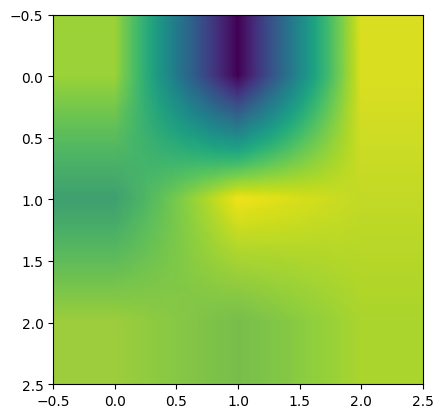

In [52]:
graph_data = []
for i in range(1, 53):
    subcarrier_graph_data = euclidean_distances.loc[(euclidean_distances['subcarrier'] == i) & (euclidean_distances['activity'] == 'SittingDown-Stationary')]
    graph_data.append(np.array(subcarrier_graph_data['amplitude_diff']).reshape(3,3))
    
plt.imshow(graph_data[0], cmap=plt.cm.viridis_r, interpolation='nearest')
for i in range(1, len(graph_data)-1):
    alpha = 1.0 - (i / len(graph_data))
    plt.imshow(graph_data[i], cmap=plt.cm.viridis_r, alpha = alpha, interpolation='bilinear')
plt.show()

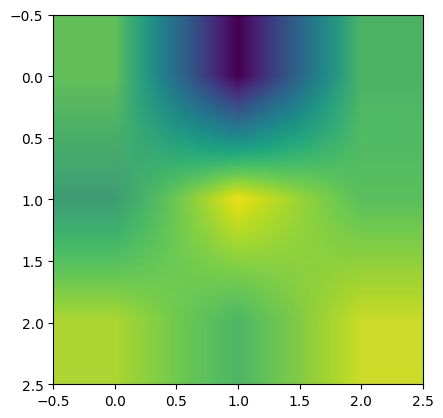

In [53]:
graph_data = []
for i in range(1, 53):
    subcarrier_graph_data = euclidean_distances.loc[(euclidean_distances['subcarrier'] == i) & (euclidean_distances['activity'] == 'SittingDown-Movement')]
    graph_data.append(np.array(subcarrier_graph_data['amplitude_diff']).reshape(3,3))
    
plt.imshow(graph_data[0], cmap=plt.cm.viridis_r, interpolation='nearest')
for i in range(1, len(graph_data)-1):
    alpha = 1.0 - (i / len(graph_data))
    plt.imshow(graph_data[i], cmap=plt.cm.viridis_r, alpha = alpha, interpolation='bilinear')
plt.show()

In [54]:
subcarrier_1 = euclidean_distances.loc[(euclidean_distances['subcarrier'] == 1) & (euclidean_distances['activity'] == 'Standing-Stationary')]
subcarrier_1_graph = np.array([1,0,0,0,0,0,0,0,0]).reshape(3,3)

In [55]:
subcarrier_1_graph

array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [56]:
subcarrier_2 = euclidean_distances.loc[(euclidean_distances['subcarrier'] == 50) & (euclidean_distances['activity'] == 'Standing-Stationary')] 
subcarrier_2_graph = np.array([1,0,0,0,0,0,0,0,0]).reshape(3,3)

In [36]:
subcarrier_2

voxel  subcarrier             activity  amplitude_diff  phase_diff
0      1          50  Standing-Stationary        2.635802    5.177930
0      2          50  Standing-Stationary        7.107318    5.559332
0      3          50  Standing-Stationary        2.920077    5.666181
0      4          50  Standing-Stationary        2.998668    5.731921
0      5          50  Standing-Stationary        5.504578    6.051990
0      6          50  Standing-Stationary        3.289152    5.460641
0      7          50  Standing-Stationary        2.076382    5.536491
0      8          50  Standing-Stationary        4.020166    5.746726
0      9          50  Standing-Stationary        2.546838    5.551794

In [57]:
subcarrier_2_graph

array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

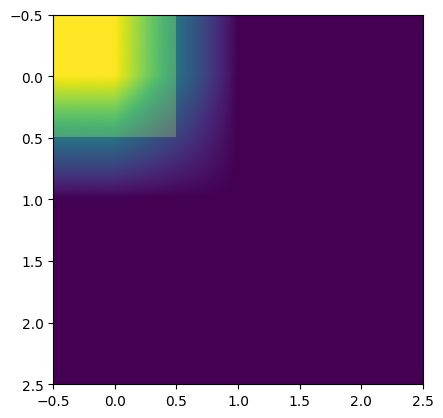

In [71]:
plt.imshow(subcarrier_1_graph, cmap=plt.cm.viridis, interpolation='nearest')
plt.imshow(subcarrier_2_graph, cmap=plt.cm.viridis, alpha=.8, interpolation='bilinear')
plt.show()

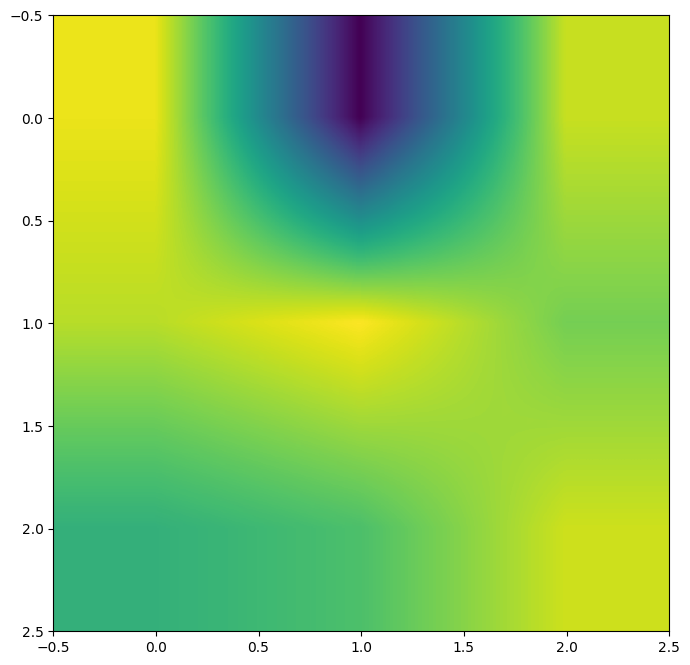

In [30]:
# Create a single plot for all subcarriers
fig, ax = plt.subplots(figsize=(8, 8))

# Iterate through each subcarrier
for subcarrier in range(52):
    subcarrier_data = euclidean_distances.loc[euclidean_distances['subcarrier'] == subcarrier + 1]
    
    # Iterate through each activity and plot the heatmap on the same plot
    for i, activity in enumerate(activities):
        activity_data = subcarrier_data.loc[subcarrier_data['activity'] == activity]
        heatmap_data = activity_data['amplitude_diff'].values.reshape(3, 3)
        if(subcarrier == 0 and i == 0): 
            im = ax.imshow(heatmap_data, cmap='gray', interpolation='nearest')
        else:
            alpha = 1.0 - (i / (len(activities) + 52))
            im = ax.imshow(heatmap_data, cmap='viridis_r', alpha=alpha, interpolation='bilinear')

plt.show()

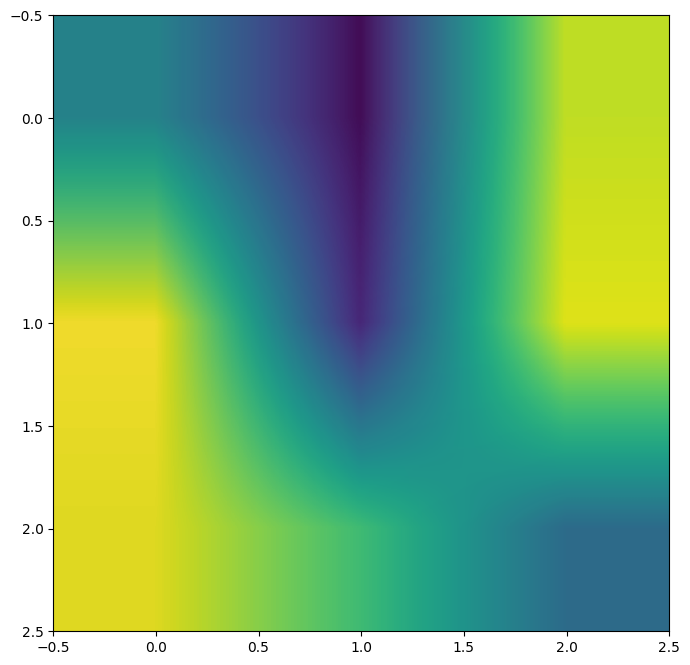

In [31]:
# Create a single plot for all subcarriers
fig, ax = plt.subplots(figsize=(8, 8))

# Iterate through each subcarrier
for subcarrier in range(52):
    subcarrier_data = euclidean_distances.loc[euclidean_distances['subcarrier'] == subcarrier + 1]
    
    # Iterate through each activity and plot the heatmap on the same plot
    for i, activity in enumerate(activities):
        activity_data = subcarrier_data.loc[subcarrier_data['activity'] == activity]
        heatmap_data = activity_data['phase_diff'].values.reshape(3, 3)
        if(subcarrier == 0 and i == 0): 
            im = ax.imshow(heatmap_data, cmap='gray', interpolation='nearest')
        else:
            alpha = 1.0 - (i / (len(activities) + 52))
            im = ax.imshow(heatmap_data, cmap='viridis_r', alpha=alpha, interpolation='bilinear')

plt.show()

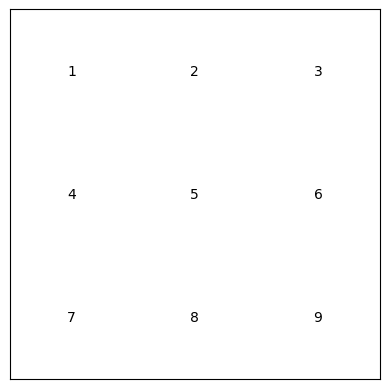

In [85]:
import matplotlib.pyplot as plt

# Create an empty 3x3 grid with cell numbers from 1 to 9
empty_grid = np.zeros((3,3))

# Plot the empty grid with cell values annotated and all cells in white
plt.imshow(empty_grid, cmap='gray_r', interpolation='nearest')
index = 1
for i in range(3):
    for j in range(3):
        plt.text(j, i, index, ha='center', va='center', color='black')
        index+=1
plt.xticks([])
plt.yticks([])
plt.show()
plt.show()

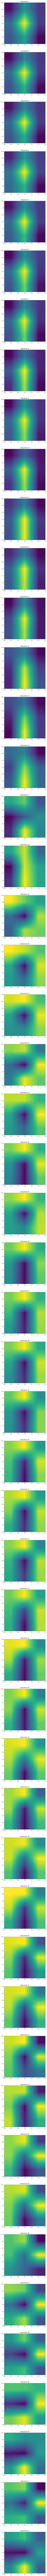

In [188]:
# Create subplots for each subcarrier
fig, axs = plt.subplots(nrows=52, ncols=1, figsize=(8, 8*52))

# Iterate through each subcarrier
for subcarrier in range(52):
    subcarrier_data = euclidean_distances.loc[euclidean_distances['subcarrier'] == subcarrier + 1]
    
    # Iterate through each activity and plot the heatmap on the corresponding subplot
    for i, activity in enumerate(activities):
        activity_data = subcarrier_data.loc[subcarrier_data['activity'] == activity]
        heatmap_data = activity_data['amplitude_diff'].values.reshape(3, 3)
        ax = axs[subcarrier]
        im = ax.imshow(heatmap_data, cmap='viridis', alpha=0.5, interpolation='bilinear')
        ax.set_title(f'Subcarrier {subcarrier + 1}')

plt.show()

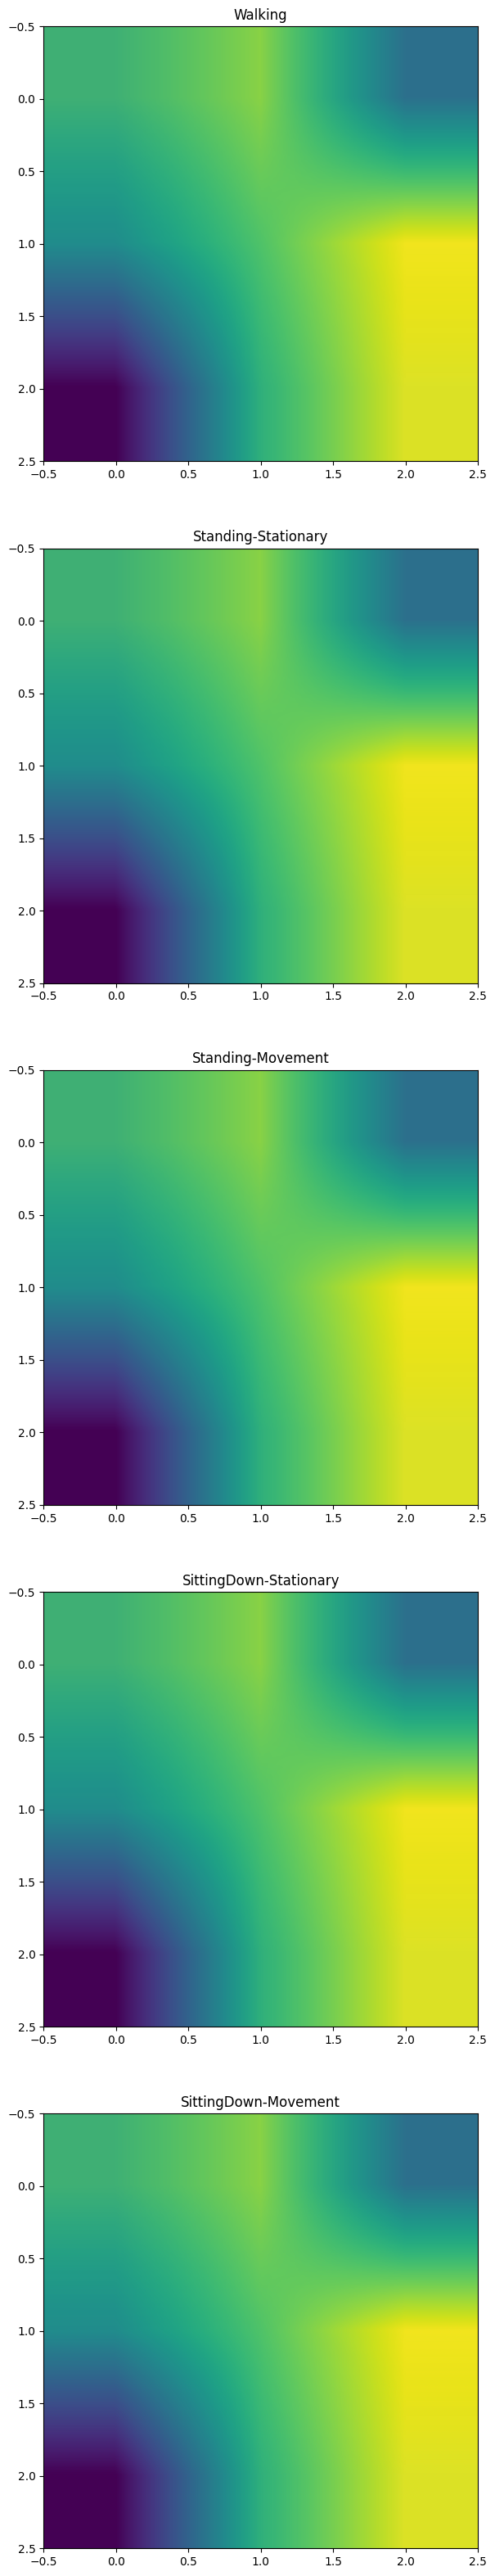

In [257]:
# Create subplots for each activity
fig, axs = plt.subplots(nrows=len(activities), ncols=1, figsize=(8, 8*len(activities)))

# Iterate through each activity
for i, activity in enumerate(activities):
    activity_data = euclidean_distances.loc[euclidean_distances['activity'] == activity]
    for subcarrier in range(52):
        subcarrier_data = activity_data.loc[activity_data['subcarrier'] == subcarrier + 1]
        heatmap_data = subcarrier_data['phase_diff'].values.reshape(3, 3)
        ax = axs[i]
        im = ax.imshow(heatmap_data, cmap='viridis', alpha=0.5, interpolation='bilinear')
        ax.set_title(activity)

plt.show()